# 머신러닝   
       
13주 1강: 의사 결정 트리

이번 시간에는 분기를 통해서 문제를 푸는 의사 결정 트리를 구현해 봅시다

## Decision Tree
**의사결정나무(decision tree)** 는 여러 가지 규칙을 순차적으로 적용하면서 독립 변수 공간을 분할하는 분류 모형입니다. 분류(classification)와 회귀 분석(regression)에 모두 사용될 수 있기 때문에 **CART(Classification And Regression Tree)** 라고도 합니다.

## 간단한 구현 (?)
* 일단 교과서의 표 12-1을 불러와 봅시다. 나이와 소득등에 따라 컴퓨터를 구매할지를 확인하는 작은 테스트 데이터입니다.
* 그리고 의미없는 인덱스 데이터인 RID는 제거합시다

In [1]:
import pandas as pd 
import numpy as np

pd_data = pd.read_csv('https://raw.githubusercontent.com/AugustLONG/ML01/master/01decisiontree/AllElectronics.csv')
pd_data = pd_data.drop("RID", axis=1)

### 정보 이득 함수
* y값의 클래스를 기준으로 엔트로피 계산을 해 봅시다.
  * 예를 들어서 `class_buys_computer`가 yes인 경우와 no인 경우를 나눕시다
  * $Info(D)=-\sum_{i=1}^n p_i \log_2 (p_i)$

In [2]:
def get_info(df):
    buy = df.loc[df["class_buys_computer"]=="yes"]
    not_buy = df.loc[df["class_buys_computer"]=="no"]
    x = np.array([len(buy)/len(df),len(not_buy)/len(df)])
    y = np.log2(x[x!=0])
    
    info_all = - sum(x[x!=0] * y)
    return info_all

In [3]:
get_info(pd_data)

np.float64(0.9402859586706311)

* 이제 각 속성들의 클래스를 기준으로 데이터를 추출하고, 정보량을 구해봅시다.

In [4]:
youth = pd_data.loc[pd_data['age'] == "youth"]
senior = pd_data.loc[pd_data['age'] == "senior"]
middle_aged = pd_data.loc[pd_data['age'] == "middle_aged"]

In [5]:
print(get_info(youth))

0.9709505944546686


In [6]:
print(get_info(senior))

0.9709505944546686


In [7]:
print(get_info(middle_aged))

-0.0


* 이제 속성을 이볅하면 자동으로 정보 이득을 계산하는 함수를 구해봅시다. 
  * 속성별 정보량은 아래와 같습니다
  * $Info_{att}(D) = -\sum_{j=1}^v \frac{|D_j|}{D}\times Info(D_j)$
  * 즉, 각 속성의 분기별 정보량을 비율대로 가중치 합을 한 값입니다. 

In [8]:
def get_attribute_info(df, attribute_name):
    attribute_values = pd_data[attribute_name].unique()
    get_infos = []
    for value in attribute_values:
        split_df = pd_data.loc[pd_data[attribute_name] == value]
        
        get_infos.append((len(split_df) / len(df)) * get_info(split_df))
    
    return sum(get_infos)

In [9]:
# 예를 들어 age는 아래와 같습니다
get_attribute_info(pd_data, "age")

np.float64(0.6935361388961918)

* 이제 정보 이득을 구해봅시다.
  * 원래 정보양에서 속성별 정보량을 빼면 됩니다.

In [10]:
get_info(pd_data) - get_attribute_info(pd_data, "age")

np.float64(0.24674981977443933)

In [11]:
get_info(pd_data) - get_attribute_info(pd_data, "income")

np.float64(0.02922256565895487)

In [12]:
get_info(pd_data) - get_attribute_info(pd_data, "student")

np.float64(0.15183550136234159)

In [13]:
get_info(pd_data) - get_attribute_info(pd_data, "credit_rating")

np.float64(0.04812703040826949)

* 정보이득이 가장 큰 age를 기준으로 의사결정트리 가지를 만듭시다

In [14]:
youth = pd_data.loc[pd_data['age'] == "youth"]

* 그리고 이제 age가 youth인 데이터를 기준으로 가지를 분할해 봅시다.

In [15]:
get_info(youth) - get_attribute_info(youth, "income")

np.float64(-1.580026905978025)

In [16]:
get_info(youth) - get_attribute_info(youth, "student")

np.float64(-1.2367106860085422)

In [17]:
get_info(youth) - get_attribute_info(youth, "credit_rating")

np.float64(-1.527094404679944)

* 위의 데이터를 고려하면 정보 이득이 가장 큰 "student" 기준으로 다시 분할이 일어날 것입니다.

## Scikit-learn으로 구현하기

* 잘 구현된 Scikit-learn이 있으므로 이제 힘들게 직접 구현은 하지 맙시다.

* 일단 타이타닉 데이터를 불러오겠습니다.

In [18]:
import pandas as pd

train_df = pd.read_csv("W13/train.csv")
test_df = pd.read_csv("W13/test.csv")

train_id = train_df["PassengerId"].values # 전처리 후에 Train과 Test를 구분하기 위해서...
test_id = test_df["PassengerId"].values

all_df = pd.concat([train_df,test_df]).set_index('PassengerId') # 교과서 코드가 이상해서 수정

### 데이터 전처리
* 일단 데이터를 부호화시키고 결측치를 채우겠습니다.
  * 교과서는 replace를 썼지만, dict로 입력을 넣으려면 제 생각에는 map이 더 좋은 선택입니다.

In [19]:
all_df["Sex"] = all_df["Sex"].map({"male":0,"female":1}).astype(int) #다운캐스팅을 명시적으로 셋팅해야 합니다. 교과서 코드 수정

# 데이터 중 age 값의 빈칸의 값을 `class의 평균값으로 채운다.
all_df["Age"] = all_df["Age"].fillna(all_df.groupby("Pclass")["Age"].transform("mean")) #inplace는 권장되지 않습니다. 교과서 코드 수정

In [20]:
all_df["cabin_count"] = all_df["Cabin"].map(
         lambda x : len(x.split()) if type(x) == str else 0)

In [21]:
def transform_status(x):
    if "Mrs" in x or "Ms" in x: # 교과서 따라 하는 것이긴 한데요. Mrs와 MS는 다르긴 하죠.
        return "Mrs" 
    elif "Mr" in x:
        return "Mr"
    elif "Miss" in x:
        return "Miss"
    elif "Master" in x:
        return "Master"
    elif "Dr" in x:
        return "Dr"
    elif "Rev" in x:
        return "Rev"
    elif "Col" in x:
        return "Col"
    else:
        return "0"

all_df["social_status"] = all_df["Name"].map(lambda x : transform_status(x))

In [22]:
all_df["social_status"].value_counts()

social_status
Mr        758
Miss      258
Mrs       203
Master     61
0           9
Rev         8
Dr          8
Col         4
Name: count, dtype: int64

* 사용하지 않을 데이터는 지워줍시다. Embarked가 비워져 있는 62번과 830번을 지우겠습니다. 

In [23]:
all_df[all_df["Embarked"].isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,cabin_count,social_status
PassengerId,,,,,,,,,,,,,
62,1.0,1,"Icard, Miss. Amelie",1,38.0,0,0,113572,80.0,B28,NaN,1,Miss
830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",1,62.0,0,0,113572,80.0,B28,NaN,1,Mrs


In [24]:
all_df = all_df.drop([62,830])
train_id = np.delete(train_id, [62-1,830-1]) # 62번과 830번은 train set에 있습니다

* 적당히 빈 데이터 값을 채워주기도 해  봅시다.

In [25]:
all_df[all_df["Fare"].isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,cabin_count,social_status
PassengerId,,,,,,,,,,,,,
1044,NaN,3,"Storey, Mr. Thomas",0,60.5,0,0,3701,NaN,NaN,S,0,Mr


In [26]:
all_df.groupby(["Pclass","Sex"])["Fare"].mean() # 성별과 객실에 따른 요금 평균을 봅시다.

Pclass  Sex
1       0       69.888385
        1      109.826644
2       0       19.904946
        1       23.234827
3       0       12.415462
        1       15.324250
Name: Fare, dtype: float64

In [27]:
all_df.loc[all_df["Fare"].isnull(), "Fare"] = 12.415462 # 하드코딩... 입니다만 교과서가 이리 했으니

* Cabin은 객실 번호입니다. 
  * 객실 번호에서 맨 앞의 알파벳만 따 옵니다. 이건 객실의 종류를 의미하는 것 같습니다.

In [28]:
all_df["cabin_type"] = all_df["Cabin"].map(lambda x : x[0] if type(x) == str else "99")

In [29]:
all_df["cabin_type"].unique()

array(['99', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

불필요해진 정보는 이제 지워봅시다. 

In [30]:
del all_df["Cabin"]
del all_df["Name"]
del all_df["Ticket"]

In [31]:
y = all_df.loc[train_id, "Survived"].values
del all_df["Survived"]

### 원핫인코딩과 데이터 스케일링
* 카테고리 데이터를 원핫벡터로 만듭시다.

In [32]:
X_df = pd.get_dummies(all_df)
X = X_df.values

* MinMax Scaling도 해 줍시다.

In [33]:
from sklearn.preprocessing import MinMaxScaler
minmax_scaler = MinMaxScaler()

minmax_scaler.fit(X)
X = minmax_scaler.transform(X)

* Train set과 Test set을 다시 나눕시다.

In [34]:
X_train = X[:len(train_id)]
X_test = X[len(train_id):]

### 학습하기
* DecisionTreeClassifier 객체를 생성합니다.
* 주요 하이퍼 매개변수
  * "criterion" : \["gini", "entropy"\] : 지니 계수를 기준으로 나눌지, 정보 이득을 기준으로 나눌지 지정
  * "max_depth" : int : 트리의 깊이를 지정
  * "min_samples_leaf" : int or float : 마지막 노드의 최소 데이터의 개수를 지정
    * int는 데이터의 개수를 정해주고, float은 전체 데이터에서의 비율을 정해주는 것입니다.
    * 아래에서 "min_samples_leaf" 수를 3개부터 점점 키워가면서 정확도를 재 봅시다.

<Axes: >

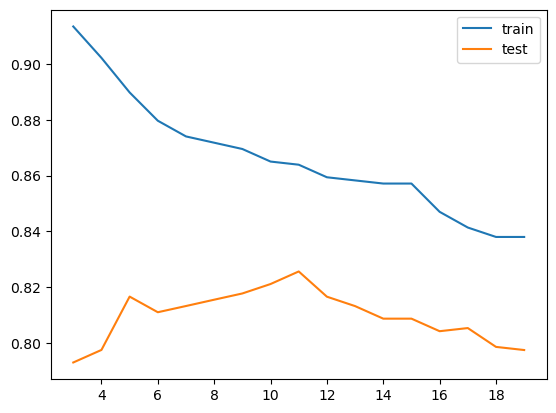

In [35]:
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score  

test_accuracy = []
train_accuracy = []
for idx in range(3, 20):
    df = DecisionTreeClassifier(min_samples_leaf=idx)
    acc = cross_val_score(df, X_train, y, scoring="accuracy", cv=5).mean()
    train_accuracy.append(
        accuracy_score(df.fit(X_train, y).predict(X_train), y))
    test_accuracy.append(acc)

result = pd.DataFrame(train_accuracy, index=range(3,20), columns=["train"])
result["test"] = test_accuracy

result.plot()

* test 데이터셋의 정확성은 11에서 가장 높았다가 계속 떨어집니다.
  * 의사결정트리의 경우 마지막 노드의 데이터 개수가 적으면 적을수록 과대적합이 발생할 확률이 높습니다. 

* 지난 시간에 사용했던 파이프라인을 통해 두 개 이상의 알고리즘과 매개변수에 대한 테스트를 해 봅시다. 

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

algorithmes = [LogisticRegression(max_iter=5000), DecisionTreeClassifier()]
# 기본 parameter에서 수렴을 안 해서 교과서 코드에서 iteration 수를 늘렸습니다.

c_params = [0.1,  5.0, 7.0, 10.0, 15.0, 20.0, 100.0]


params = []
params.append([{
    "solver" : ["saga"], # Multinomial
    "penalty" : ["l1"],
    "C" : c_params,
    },{
    "solver" : ['liblinear'], # OVR
    "penalty" : ["l2"],
    "C" : c_params,
    }
    ])
params.append({
    "criterion" : ["gini", "entropy"], # 분할 기준
    "max_depth" : [10,8,7,6,5,4,3,2], # 최대 깊이
    "min_samples_leaf": [1,2,3,4,5,6,7,8,9]}) # leaf node의 최소 데이터 수

* Grid Search를 해 봅시다.

In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

scoring = ['accuracy']
estimator_results = []
for i, (estimator, params) in enumerate(zip(algorithmes,params)):
    gs_estimator = GridSearchCV( # Accuracy 기준으로 best parameter를 찾습니다
            refit="accuracy", estimator=estimator,param_grid=params,
            scoring=scoring, cv=5, verbose=1, n_jobs=4)

    gs_estimator.fit(X_train, y)
    estimator_results.append(gs_estimator)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 144 candidates, totalling 720 fits


/home/jhyun/anaconda3/envs/ml2024/lib/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


* Logistic Regression과 Decision Tree 각각의 best estimator를 찾을 수 있습니다. 

In [38]:
estimator_results[0]

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=5000), n_jobs=4,
             param_grid=[{'C': [0.1, 5.0, 7.0, 10.0, 15.0, 20.0, 100.0],
                          'penalty': ['l1'], 'solver': ['saga']},
                         {'C': [0.1, 5.0, 7.0, 10.0, 15.0, 20.0, 100.0],
                          'penalty': ['l2'], 'solver': ['liblinear']}],
             refit='accuracy', scoring=['accuracy'], verbose=1)

In [39]:
estimator_results[1]

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=4,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 8, 7, 6, 5, 4, 3, 2],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
             refit='accuracy', scoring=['accuracy'], verbose=1)

* 둘 중에 뭐가 더 나은 선택일까요?
  * best_score_ 는 위에서 지정한 accuracy를 기준으로 Logistic Regression과 Decision Tree의 최고 점수를 보여줍니다

In [40]:
# Logistic Regression
estimator_results[0].best_score_

np.float64(0.8268075922046594)

In [41]:
# Decision Tree
estimator_results[1].best_score_
# Decision tree가 조금 더 나은 성능을 보여줍니다.

np.float64(0.8358154002412238)

* 전체의 점수를 DF로 만들어 확인해 봅시다.

In [42]:
import pandas as pd
from pandas import DataFrame
from collections import defaultdict

result_df_dict = {}

result_attributes = ["model", "accuracy", "penalty", "solver", "C", "criterion", "max_depth", "min_samples_leaf"]
result_dict = defaultdict(list)

algorithm_name= ["LogisticRegression", "DecisionTreeClassifier"]

for i, estimators in enumerate(estimator_results):
    number_of_estimators = len(estimators.cv_results_["mean_fit_time"])

    for idx_estimator in range(number_of_estimators):
        result_dict["model"].append(algorithm_name[i])
        result_dict["accuracy"].append(
            estimators.cv_results_["mean_test_accuracy"][idx_estimator])
            
    for param_value in estimators.cv_results_["params"]:
        for k,v in param_value.items():
            result_dict[k].append(v)
    for attr_name in result_attributes:
        if len(result_dict[attr_name]) < len(result_dict["accuracy"]):
            result_dict[attr_name].extend([None for i in range(number_of_estimators)])

* 최종적으로 엔트로피로 최대 깊이 4, min_samples_leaf 7일때 가장 좋은 성능을 보입니다
  * 다만 파라미터가 바뀌어도 성능은 꽤나 안정적인 것으로 보입니다.

In [43]:
result_df = DataFrame(result_dict, columns=result_attributes)
result_df.sort_values("accuracy",ascending=False).head()

,model,accuracy,penalty,solver,C,criterion,max_depth,min_samples_leaf
137,DecisionTreeClassifier,0.835815,None,None,NaN,entropy,4.0,7.0
136,DecisionTreeClassifier,0.834692,None,None,NaN,entropy,4.0,6.0
138,DecisionTreeClassifier,0.833556,None,None,NaN,entropy,4.0,8.0
132,DecisionTreeClassifier,0.832445,None,None,NaN,entropy,4.0,2.0
133,DecisionTreeClassifier,0.832445,None,None,NaN,entropy,4.0,3.0


### 시각화와 Feature Importance
* 의사 결정 트리의 장점 중 하나는 우리가 어떤 Feature를 더 중요하게 고려해야 하는지를 보여준다는 것입니다. 
  * `.best_estimator_.feature_importances_` 는 각 feature의 중요도를 보여줍니다

In [44]:
estimator_results[1].best_estimator_.feature_importances_

array([0.13376524, 0.06257368, 0.04358764, 0.        , 0.        ,
       0.18883257, 0.01350244, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.04383854, 0.        ,
       0.5138999 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

* 이것은 원래의 X_train의 feature 순서와 같으므로, 아래의 순서를 의미합니다.

In [45]:
X_df.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'cabin_count',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'social_status_0',
       'social_status_Col', 'social_status_Dr', 'social_status_Master',
       'social_status_Miss', 'social_status_Mr', 'social_status_Mrs',
       'social_status_Rev', 'cabin_type_99', 'cabin_type_A', 'cabin_type_B',
       'cabin_type_C', 'cabin_type_D', 'cabin_type_E', 'cabin_type_F',
       'cabin_type_G', 'cabin_type_T'],
      dtype='object')

* 저렇게 보면 비교가 어려우니, 순서를 정리하고 중요한 순서대로 봅시다.
  * `numpy.argsort`는 array를 정렬하는 순서의 index를 반환해 줍니다.

In [46]:
coef = estimator_results[1].best_estimator_.feature_importances_
coef.argsort()[::-1]

array([15,  5,  0,  1, 13,  2,  6, 23, 26, 25, 24, 16, 17, 18, 19, 20, 21,
       22, 14,  8,  9, 10, 11, 12,  7,  4,  3])

In [47]:
X_df.columns[coef.argsort()[::-1]][:5]

Index(['social_status_Mr', 'Fare', 'Pclass', 'Sex', 'social_status_Master'], dtype='object')

* 하나의 노드를 기준으로 어떤 속성에 대해서 어떤 기준으로 가지가 발생했는지, 각 가지마다 데이터의 개수가 어떻게 나누어지는지를 pydot으로 볼 수 있습니다.
* pydot은 Graphviz의 DOT 언어를 파이썬으로 다루기 위한 라이브러리입니다.
  * Graphviz는 그래프 시각화를 위한 오픈소스 도구입니다.

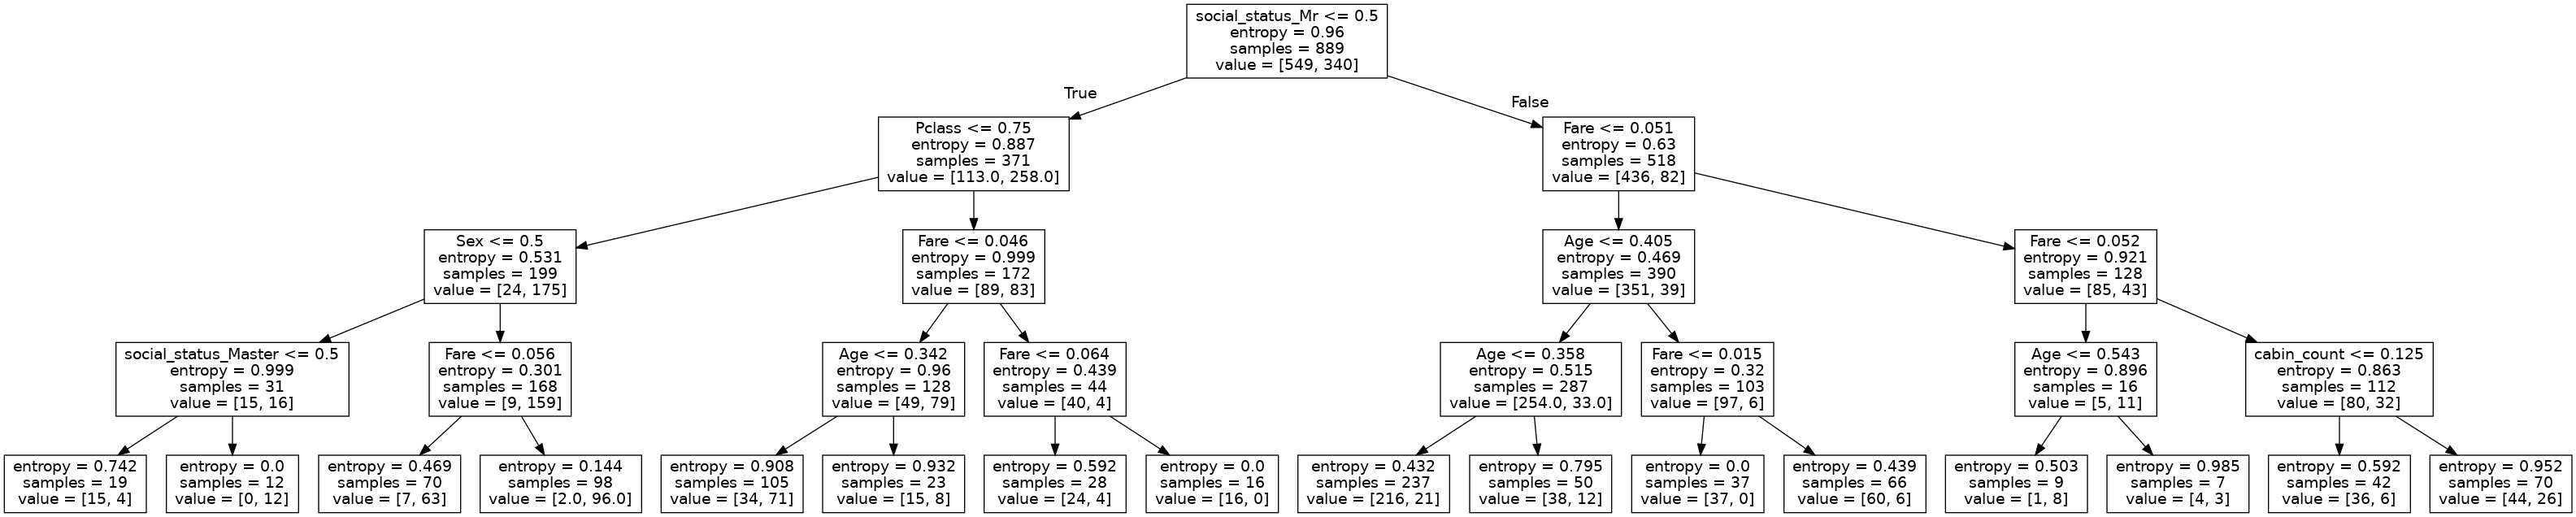

In [48]:
import pydot
from six import StringIO
from sklearn import tree
from IPython.core.display import Image

best_tree = estimator_results[1].best_estimator_
column_names = X_df.columns

dot_data = StringIO()
tree.export_graphviz(best_tree, out_file=dot_data, feature_names=column_names) 

graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]
image = graph.create_png()
Image(image)

# 교과서는 pydotplus로 구현했으나, 저는 더 대중적인 pydot으로 구현했습니다.
# pydot이 한동안 유지보수가 안 되다가, 2024년부턴 다시 업데이트가 됩니다. 

## 분류 문제 돌아보기

여기에서는 붓꽃(Iris)분류 문제를 예를 들어 의사결정나무를 설명합니다. 이 예제에서는 독립변수 공간을 공간상에 표시하기 위해 꽃의 길이와 폭만을 독립변수로 사용합시다.

In [49]:
from sklearn.datasets import load_iris

data = load_iris()
y = data.target
X = data.data[:, 2:]
feature_names = data.feature_names[2:]

from sklearn.tree import DecisionTreeClassifier
 
tree1 = DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0).fit(X, y)

다음은 의사결정나무를 시각화하기 위한 코드입니다. `draw_decision_tree` 함수는 의사결정나무의 의사 결정 과정의 세부적인 내역을 다이어그램으로 보여주고  `plot_decision_regions` 함수는 이러한 의사 결정에 의해 데이터의 영역이 어떻게 나뉘어졌는지를 시각화하여 보여줍니다.

In [50]:
import io
import pydot
from IPython.core.display import Image
from sklearn.tree import export_graphviz
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

def draw_decision_tree(model):
    dot_buf = io.StringIO()
    export_graphviz(model, out_file=dot_buf, feature_names=feature_names)
    graph = pydot.graph_from_dot_data(dot_buf.getvalue())[0]
    image = graph.create_png()
    return Image(image)

In [51]:
def plot_decision_regions(X, y, model, title):
    resolution = 0.01
    markers = ('s', '^', 'o')
    colors = ('red', 'blue', 'lightgreen')
    cmap = mpl.colors.ListedColormap(colors)

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = model.predict(
        np.array([xx1.ravel(), xx2.ravel()]).T).reshape(xx1.shape)

    plt.contour(xx1, xx2, Z, cmap=mpl.colors.ListedColormap(['k']))
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8,
                    c=[cmap(idx)], marker=markers[idx], s=80, label=cl)

    plt.xlabel(data.feature_names[2])
    plt.ylabel(data.feature_names[3])
    plt.legend(loc='upper left')
    plt.title(title)

    return Z

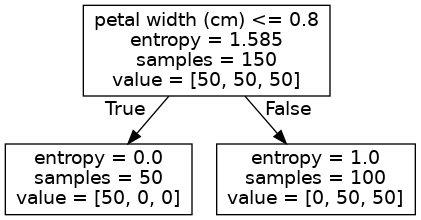

In [52]:
draw_decision_tree(tree1)

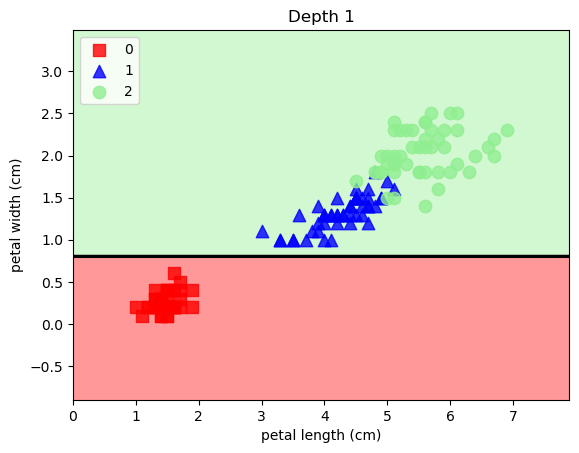

In [53]:
plot_decision_regions(X, y, tree1, "Depth 1")
plt.show()

In [54]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y, tree1.predict(X))

array([[50,  0,  0],
       [ 0, 50,  0],
       [ 0, 50,  0]])

In [55]:
tree2 = DecisionTreeClassifier(
    criterion='entropy', max_depth=2, random_state=0).fit(X, y)

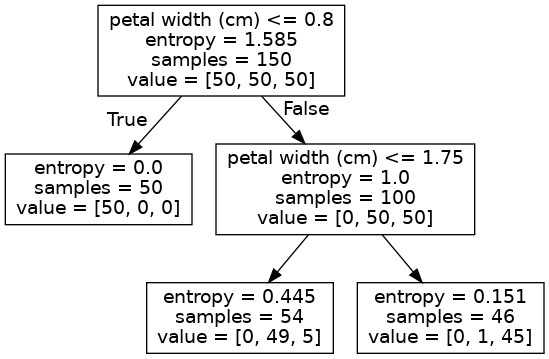

In [56]:
draw_decision_tree(tree2)

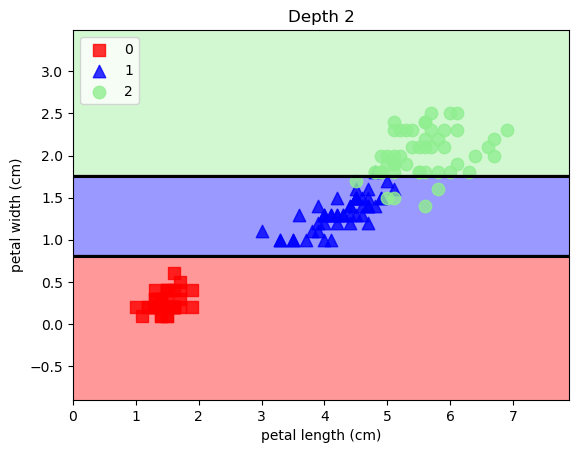

In [57]:
plot_decision_regions(X, y, tree2, "Depth 2")
plt.show()

In [58]:
confusion_matrix(y, tree2.predict(X))

array([[50,  0,  0],
       [ 0, 49,  1],
       [ 0,  5, 45]])

In [59]:
tree3 = DecisionTreeClassifier(
    criterion='entropy', max_depth=3, random_state=0).fit(X, y)

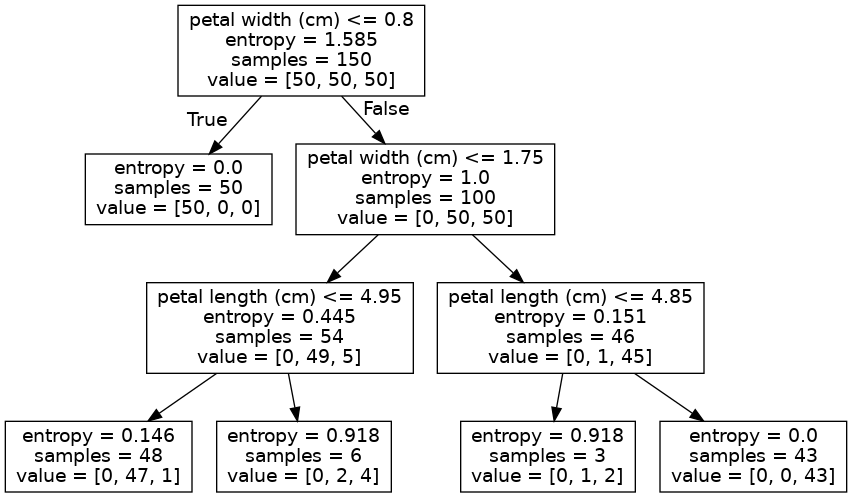

In [60]:
draw_decision_tree(tree3)

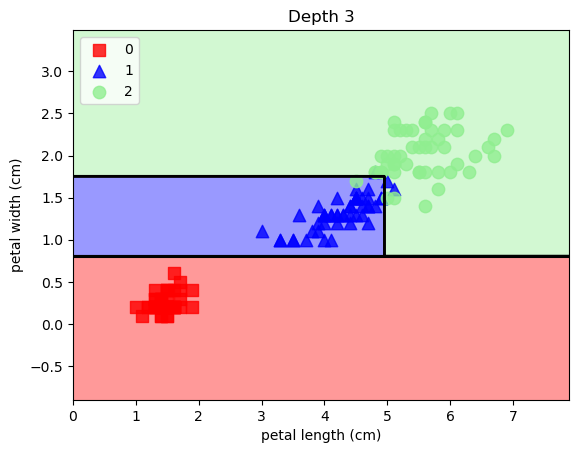

In [61]:
plot_decision_regions(X, y, tree3, "Depth 3")
plt.show()

In [62]:
confusion_matrix(y, tree3.predict(X))

array([[50,  0,  0],
       [ 0, 47,  3],
       [ 0,  1, 49]])

In [63]:
tree4 = DecisionTreeClassifier(
    criterion='entropy', max_depth=4, random_state=0).fit(X, y)

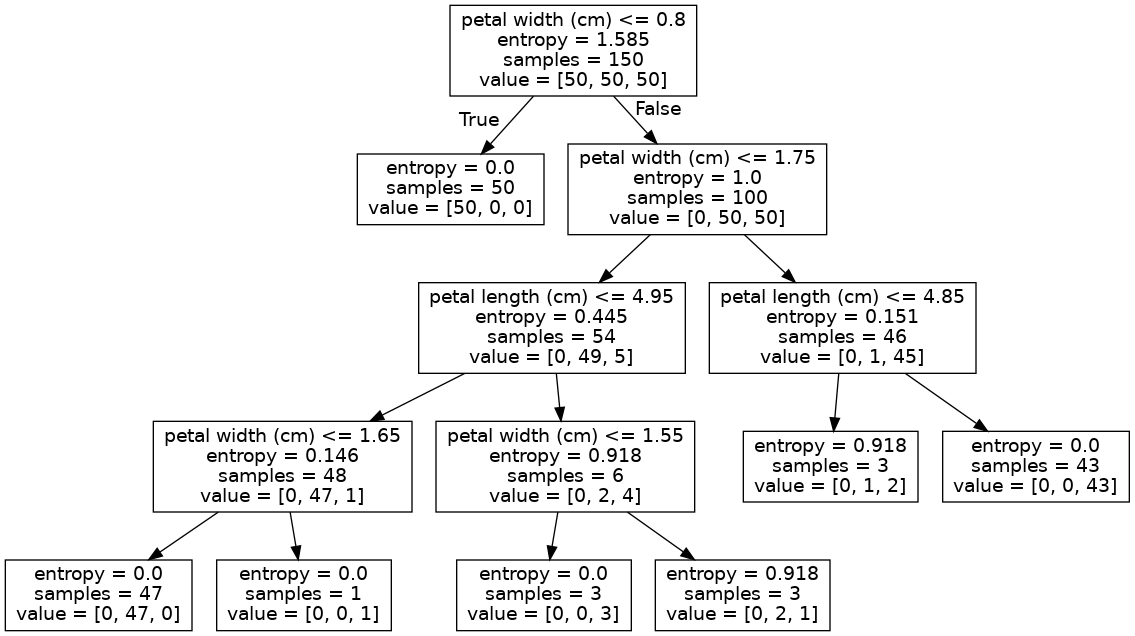

In [64]:
draw_decision_tree(tree4)

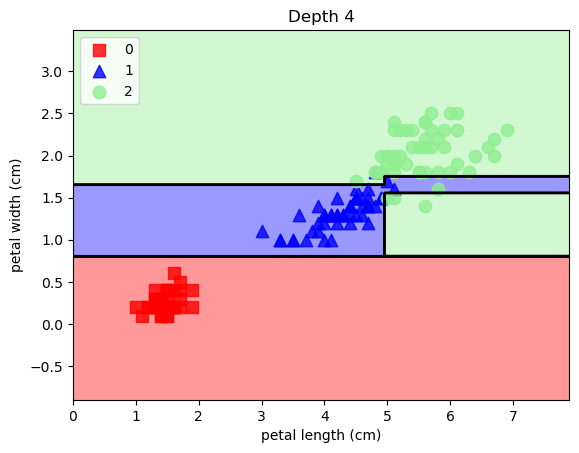

In [65]:
plot_decision_regions(X, y, tree4, "Depth 4")
plt.show()

In [66]:
confusion_matrix(y, tree4.predict(X))

array([[50,  0,  0],
       [ 0, 49,  1],
       [ 0,  1, 49]])

In [67]:
tree5 = DecisionTreeClassifier(
    criterion='entropy', max_depth=5, random_state=0).fit(X, y)

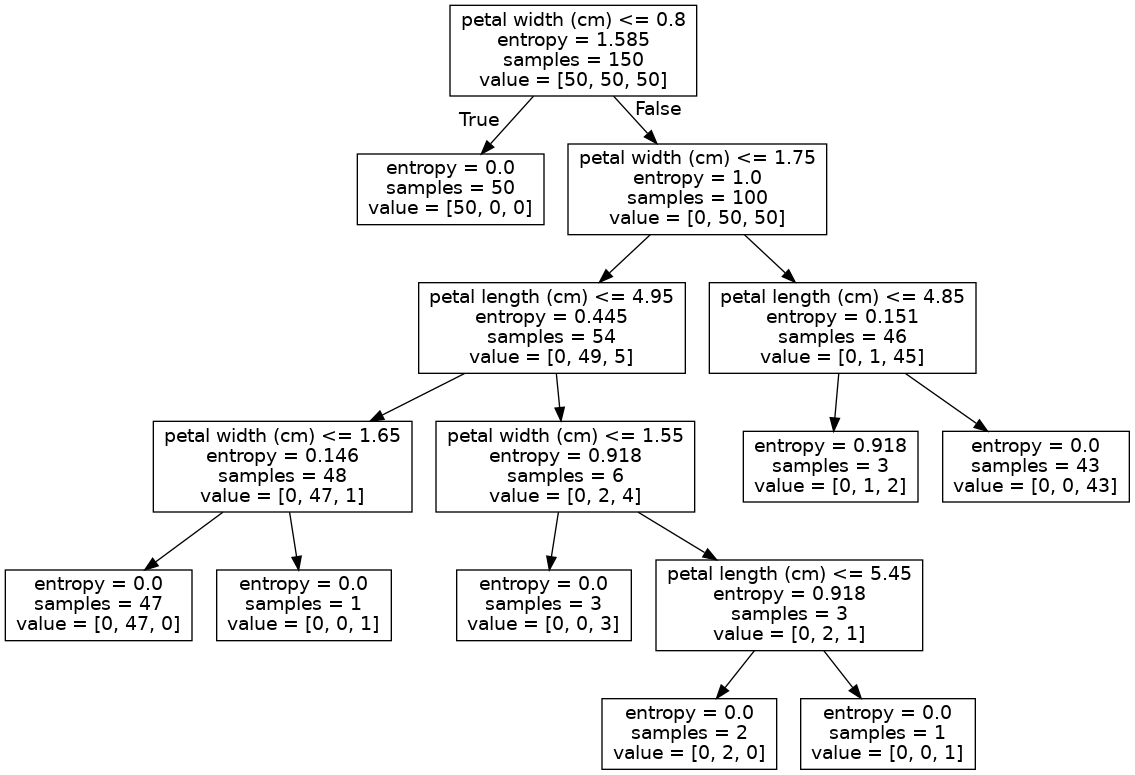

In [68]:
draw_decision_tree(tree5)

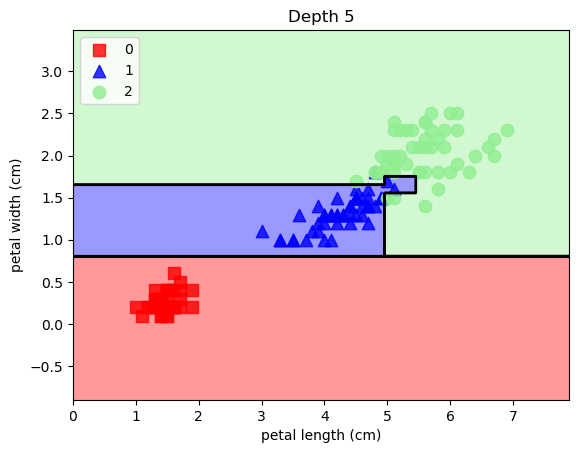

In [69]:
plot_decision_regions(X, y, tree5, "Depth 5")
plt.show()

In [70]:
confusion_matrix(y, tree5.predict(X))

array([[50,  0,  0],
       [ 0, 49,  1],
       [ 0,  0, 50]])

### Titanic Survivors, another version
* 이건 제가 다른 방식으로 구현한 titanic 분류기입니다. 
* 아까의 것과의 차이를 고려해 보세요

In [71]:
df = sns.load_dataset("titanic") # Titanic Dataset은 Seaborn으로도 불러올 수 있습니다.
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [72]:
feature_names = ["pclass", "age", "sex"]
dfX = df[feature_names].copy()
dfy = df["survived"].copy()
dfX.tail()

,pclass,age,sex
886,2,27.0,male
887,1,19.0,female
888,3,NaN,female
889,1,26.0,male
890,3,32.0,male


In [73]:
from sklearn.preprocessing import LabelEncoder
dfX["sex"] = LabelEncoder().fit_transform(dfX["sex"])
dfX.tail() 

,pclass,age,sex
886,2,27.0,1
887,1,19.0,0
888,3,NaN,0
889,1,26.0,1
890,3,32.0,1


In [74]:
dfX["age"] = dfX["age"].fillna(dfX["age"].mean())
dfX.tail()

,pclass,age,sex
886,2,27.000000,1
887,1,19.000000,0
888,3,29.699118,0
889,1,26.000000,1
890,3,32.000000,1


In [75]:
from sklearn.preprocessing import LabelBinarizer
dfX2 = pd.DataFrame(LabelBinarizer().fit_transform(dfX["pclass"]),
                    columns=['c1', 'c2', 'c3'], index=dfX.index)
dfX = pd.concat([dfX, dfX2], axis=1)
del(dfX["pclass"])
dfX.tail()

,age,sex,c1,c2,c3
886,27.000000,1,0,1,0
887,19.000000,0,1,0,0
888,29.699118,0,0,0,1
889,26.000000,1,1,0,0
890,32.000000,1,0,0,1


In [76]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(dfX, dfy, test_size=0.25, random_state=0)


model = DecisionTreeClassifier(
    criterion='entropy', max_depth=3, min_samples_leaf=5).fit(X_train, y_train)

command_buf = io.StringIO()
export_graphviz(model, out_file=command_buf, feature_names=[
                'Age', 'Sex', '1st_class', '2nd_class', '3rd_class'])
graph = pydot.graph_from_dot_data(command_buf.getvalue())[0]
image = graph.create_png()


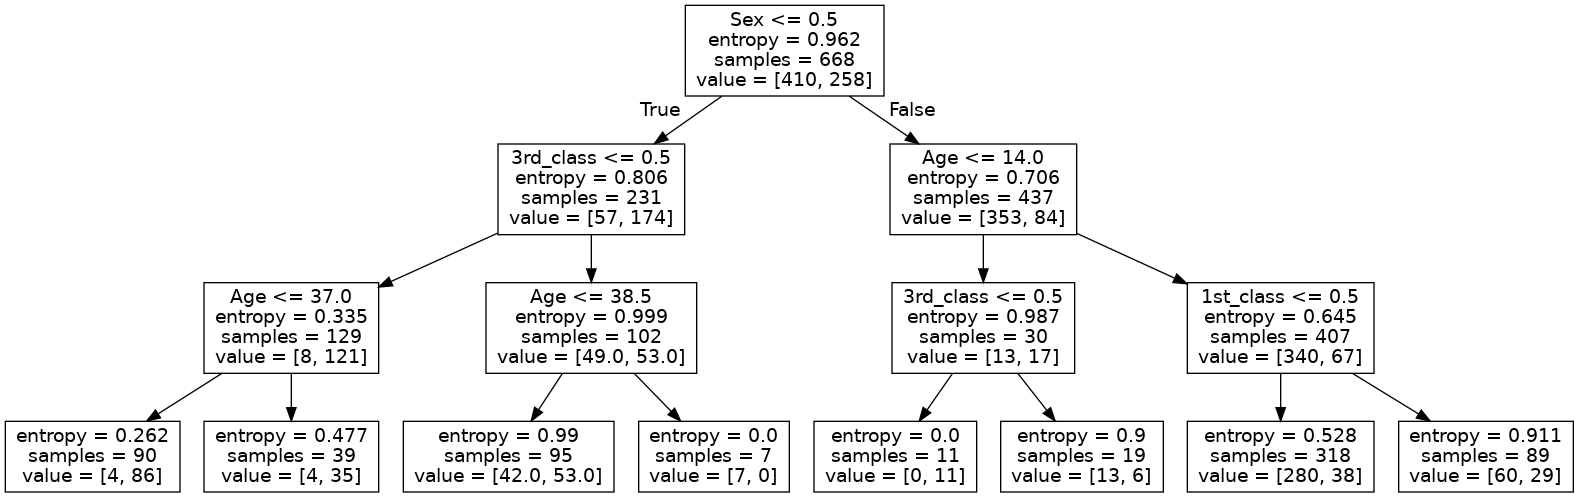

In [77]:
Image(image)

In [78]:
confusion_matrix(y_train, model.predict(X_train))

array([[360,  50],
       [ 73, 185]])

In [79]:
confusion_matrix(y_test, model.predict(X_test))

array([[119,  20],
       [ 25,  59]])

In [80]:
from sklearn.metrics import classification_report

print(classification_report(y_train, model.predict(X_train)))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85       410
           1       0.79      0.72      0.75       258

    accuracy                           0.82       668
   macro avg       0.81      0.80      0.80       668
weighted avg       0.81      0.82      0.81       668



In [81]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84       139
           1       0.75      0.70      0.72        84

    accuracy                           0.80       223
   macro avg       0.79      0.78      0.78       223
weighted avg       0.80      0.80      0.80       223



## Greedy 의사 결정

* 의사결정나무의 문제점 중 하나는 특징의 선택이 greedy한 방식으로 이루어지기 때문에 선택된 특징이 최적의 선택이 아닐 수도 있다는 점입니다. 예를 들어 데이터가 다음과 같다고 합시다

In [82]:
X = [
    [0, 0, 0],
    [1, 0, 0],
    [0, 0, 1],
    [1, 0, 1],
    [0, 1, 0],
    [1, 1, 0],
    [0, 1, 1],
    [1, 1, 1],
]
y = [0,0,1,1,1,1,0,0]

* 첫 노드에서는 $x_1, x_2, x_3$의  성능이 같습니다. 만약 첫 노드에서 특징으로 $x_1$을 선택하면 2단계로 완벽한 분류를 하는 것이 불가능하죠. 그런데 첫 특징으로 $x_1$이 아니라 $x_3$를 선택하면 2번째 단계에서 $x_2$를 선택함으로써 2단계만에 완벽한 분류를 할 수 있습니다. 하지만 이후의 상황을 첫 노드에서 특징을 결정할 때는 알 수 없습니다.

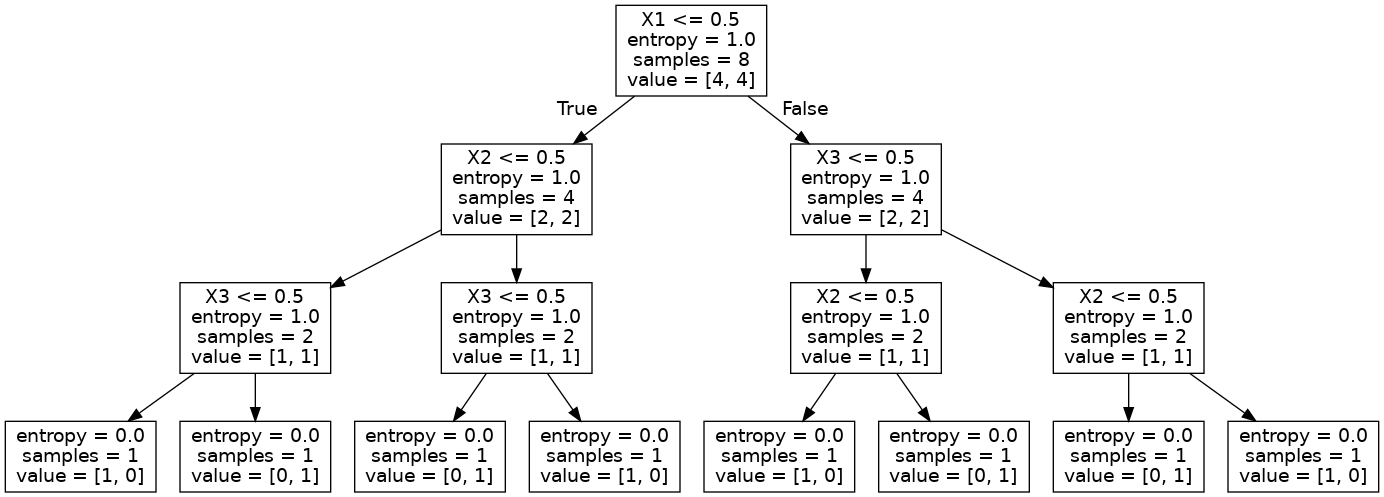

In [83]:
model = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=2).fit(X, y)
command_buf = io.StringIO()
export_graphviz(model, out_file=command_buf, 
                feature_names=["X1", "X2", "X3"])
graph = pydot.graph_from_dot_data(command_buf.getvalue())[0]
image = graph.create_png()
Image(image)

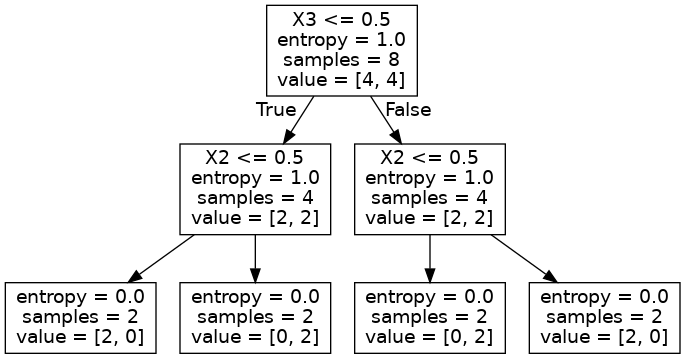

In [84]:
model = DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=3).fit(X, y)
command_buf = io.StringIO()
export_graphviz(model, out_file=command_buf, 
                feature_names=["X1", "X2", "X3"])
graph = pydot.graph_from_dot_data(command_buf.getvalue())[0]
image = graph.create_png()
Image(image)

## Regression tree

예측값 $\hat{y}$을 다음처럼 각 특징값 영역마다 고정된 값 $y_1, y_2$를 사용하고,

$$ 
\hat{y} = 
\begin{cases} 
y_1 & \text{ if } x \geq x_{\text{threshold}} \\ 
y_2 & \text{ if } x < x_{\text{threshold}}
\end{cases} $$

기준값 및 $y_1, y_2$를 선택하는 목적함수로 오차 제곱합을 사용하면 회귀분석를 할 수 있습니다. 이러한 모형을 회귀 나무(regression tree)라고 한다.

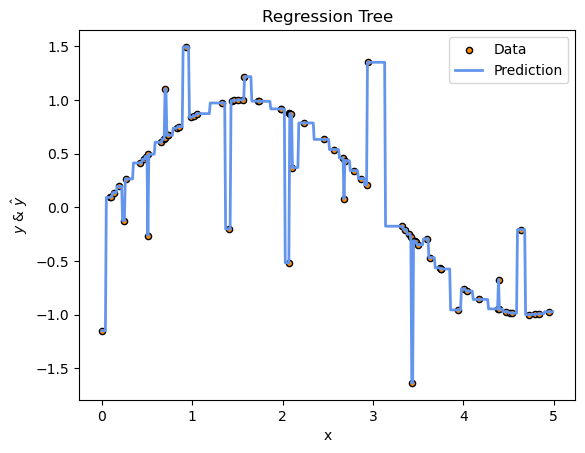

In [85]:
from sklearn.tree import DecisionTreeRegressor

rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(16))

regtree = DecisionTreeRegressor(max_depth=10)
regtree.fit(X, y)

X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_hat = regtree.predict(X_test)

# Plot the results
plt.figure()
plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="Data")
plt.plot(X_test, y_hat, color="cornflowerblue", linewidth=2, label="Prediction")
plt.xlabel("x")
plt.ylabel(r"$y$ & $\hat{y}$")
plt.title("Regression Tree")
plt.legend()
plt.show()

# Today
- (정보)엔트로피
- 의사결정나무

# Next class
- Ensemble 모델을 배워봅시다

# Reference
- https://datascienceschool.net/